# Lesson 1 - Food-101

In this lesson I will build our first image classifier from scratch using fastai.

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
from fastai.metrics import error_rate

In [3]:
bs = 64

## Looking at the data

I am going to use the [Food-101](https://www.vision.ee.ethz.ch/datasets_extra/food-101/) by Lukas Bossard, Matthieu Guillaumin, Luc Van Gool which 101 food categories, with 101,000 images; 250 test images and 750 training images per class. The training images were not cleaned. All images were rescaled to have a maximum side length of 512 pixels.

In [4]:
path = Path('input/food-101')

In [7]:
path.ls()

[PosixPath('input/food-101/images'),
 PosixPath('input/food-101/license_agreement.txt'),
 PosixPath('input/food-101/README.txt'),
 PosixPath('input/food-101/meta')]

In [5]:
path_img = path/'images'

The first thing we do when we approach a problem is to take a look at the data. We _always_ need to understand very well what the problem is and what the data looks like before we can figure out how to solve it. Taking a look at the data means understanding how the data directories are structured, what the labels are and what some sample images look like.
The main difference between the handling of image classification datasets is the way labels are stored.

In [21]:
data = ImageDataBunch.from_folder(path, train="images", valid_pct=0.2, ds_tfms=get_transforms(flip_vert=True),
        size=224, bs = bs, num_workers=4).normalize(imagenet_stats)

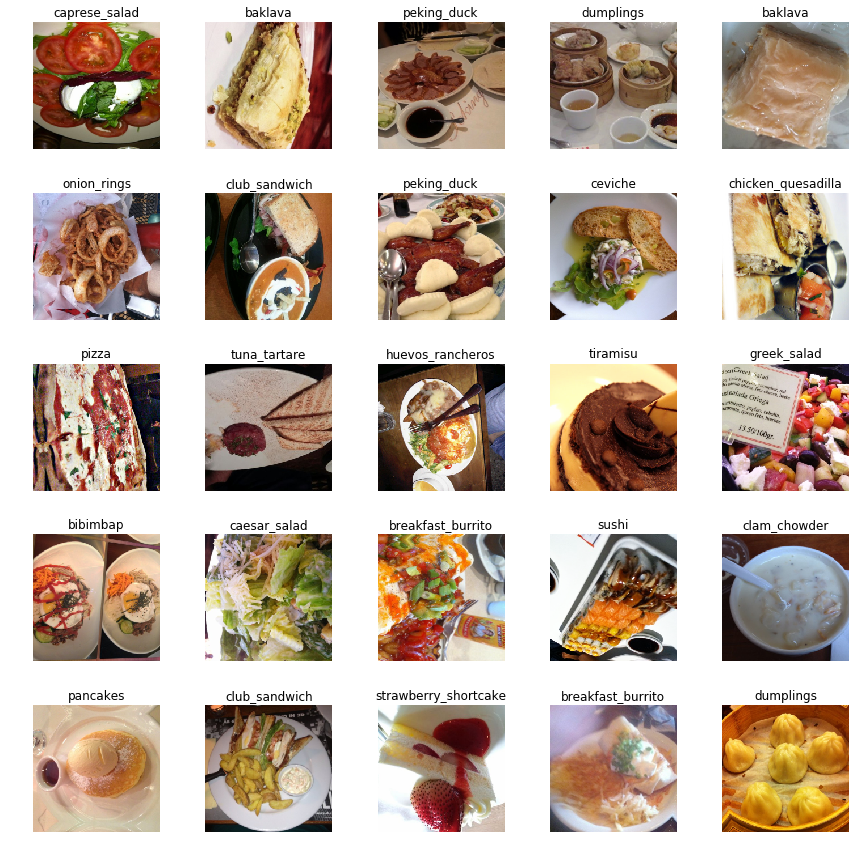

In [22]:
data.show_batch(rows = 5, figsize = (12,12))

In [23]:
print(data.classes)
len(data.classes),data.c

['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare', 'beet_salad', 'beignets', 'bibimbap', 'bread_pudding', 'breakfast_burrito', 'bruschetta', 'caesar_salad', 'cannoli', 'caprese_salad', 'carrot_cake', 'ceviche', 'cheese_plate', 'cheesecake', 'chicken_curry', 'chicken_quesadilla', 'chicken_wings', 'chocolate_cake', 'chocolate_mousse', 'churros', 'clam_chowder', 'club_sandwich', 'crab_cakes', 'creme_brulee', 'croque_madame', 'cup_cakes', 'deviled_eggs', 'donuts', 'dumplings', 'edamame', 'eggs_benedict', 'escargots', 'falafel', 'filet_mignon', 'fish_and_chips', 'foie_gras', 'french_fries', 'french_onion_soup', 'french_toast', 'fried_calamari', 'fried_rice', 'frozen_yogurt', 'garlic_bread', 'gnocchi', 'greek_salad', 'grilled_cheese_sandwich', 'grilled_salmon', 'guacamole', 'gyoza', 'hamburger', 'hot_and_sour_soup', 'hot_dog', 'huevos_rancheros', 'hummus', 'ice_cream', 'lasagna', 'lobster_bisque', 'lobster_roll_sandwich', 'macaroni_and_cheese', 'macarons', 'miso_sou

(101, 101)

## Training: resnet34

Now I will start training our model. I will use a [convolutional neural network](http://cs231n.github.io/convolutional-networks/) backbone and a fully connected head with a single hidden layer as a classifier.
I will train for 4 epochs.

In [24]:
learn = create_cnn(data, models.resnet34, metrics=error_rate)

In [25]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

In [26]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate
1,2.223791,1.727744,0.446931
2,1.935956,1.485360,0.389158
3,1.743680,1.355855,0.355049
4,1.622365,1.321854,0.346139


In [27]:
learn.save('stage_food-1')

## Results

Let's see what results we have got. 

We will first see which were the categories that the model most confused with one another. We will try to see if what the model predicted was reasonable or not. In this case the mistakes look reasonable (none of the mistakes seems obviously naive). This is an indicator that our classifier is working correctly. 

Furthermore, when we plot the confusion matrix, we can see that the distribution is heavily skewed: the model makes the same mistakes over and over again but it rarely confuses other categories. This suggests that it just finds it difficult to distinguish some specific categories between each other; this is normal behaviour.

In [28]:
interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()
len(data.valid_ds)==len(losses)==len(idxs)

True

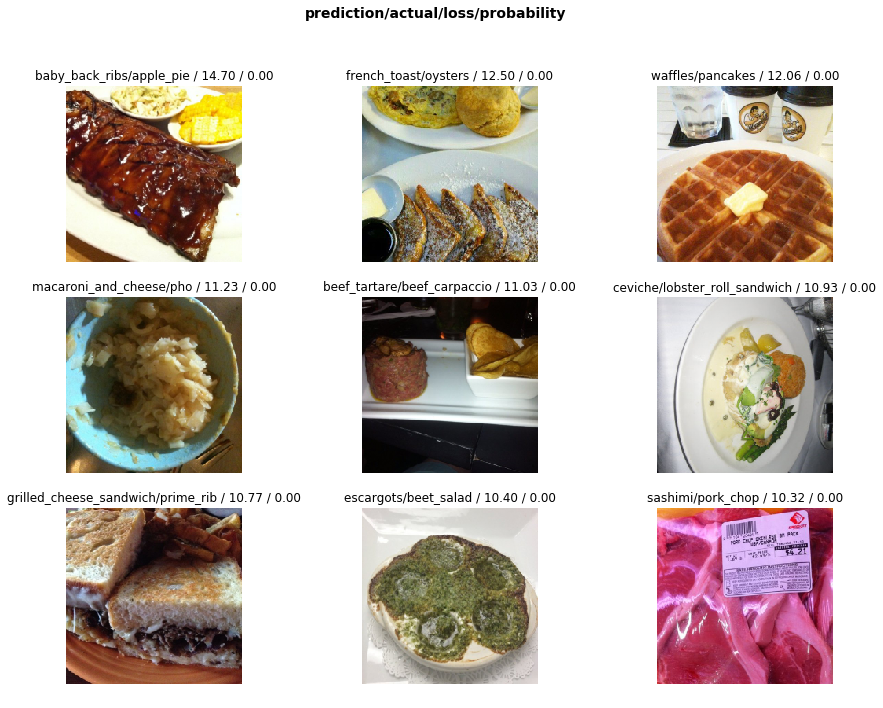

In [29]:
interp.plot_top_losses(9, figsize=(15,11))

In [ ]:
interp.plot_confusion_matrix(figsize=(20, 20), dpi=100)

## Unfreezing, fine-tuning, and learning rates

Since our model is working as we expect it to, we will *unfreeze* our model and train some more.

In [40]:
learn.unfreeze()

In [41]:
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,error_rate
1,1.326425,1.097618,0.289109


In [42]:
learn.load('stage_food-1');

In [43]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


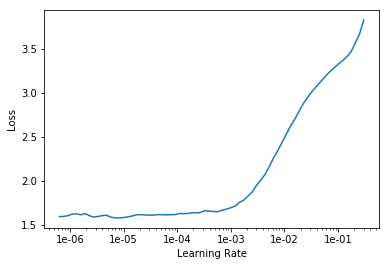

In [44]:
learn.recorder.plot()

In [45]:
learn.unfreeze()
learn.fit_one_cycle(2, max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate
1,1.502581,1.233420,0.324505
2,1.439143,1.192835,0.314554


## Training: resnet50

Now I will train in the same way as before but with one caveat: instead of using resnet34 as our backbone I will use resnet50 (resnet34 is a 34 layer residual network while resnet50 has 50 layers. 

Basically, resnet50 usually performs better because it is a deeper network with more parameters. Let's see if I can achieve a higher performance here. To help it along, let's use larger images too, since that way the network can see more detail. I reduce the batch size a bit since otherwise this larger network will require more GPU memory.

In [6]:
data = ImageDataBunch.from_folder(path, train="images", valid_pct=0.2, ds_tfms=get_transforms(flip_vert=True),
        size=224, bs = bs//2, num_workers=12).normalize(imagenet_stats)

In [7]:
learn = create_cnn(data, models.resnet50, metrics=error_rate)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


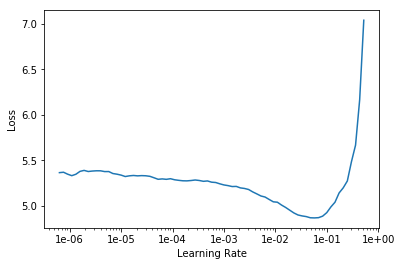

In [8]:
learn.lr_find()
learn.recorder.plot()

In [9]:
learn.fit_one_cycle(8)

epoch,train_loss,valid_loss,error_rate
1,2.052681,1.660201,0.427921
2,1.848315,1.399050,0.365000
3,1.533844,1.245567,0.327426
4,1.450544,1.145492,0.301337
5,1.348345,1.074498,0.284950
6,1.276704,1.012380,0.271881
7,1.221229,0.982378,0.263317
8,1.188295,0.974534,0.261535


In [10]:
learn.save('stage_food-1-50')

In [11]:
learn.unfreeze()
learn.fit_one_cycle(3, max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate
1,1.130576,0.942625,0.253020
2,1.120585,0.887922,0.238762
3,0.996506,0.875208,0.235891


If it doesn't, you can always go back to your previous model.

In [12]:
learn.load('stage_food-1-50');

In [13]:
interp = ClassificationInterpretation.from_learner(learn)

In [15]:
interp.most_confused(min_val=10)

[('tuna_tartare', 'beef_tartare', 27),
 ('chocolate_mousse', 'chocolate_cake', 26),
 ('prime_rib', 'steak', 25),
 ('steak', 'filet_mignon', 25),
 ('filet_mignon', 'steak', 22),
 ('steak', 'prime_rib', 21),
 ('apple_pie', 'bread_pudding', 18),
 ('pork_chop', 'grilled_salmon', 17),
 ('bread_pudding', 'apple_pie', 16),
 ('cheesecake', 'panna_cotta', 16),
 ('lasagna', 'pizza', 16),
 ('tiramisu', 'chocolate_mousse', 16),
 ('pork_chop', 'steak', 15),
 ('baby_back_ribs', 'steak', 14),
 ('huevos_rancheros', 'nachos', 14),
 ('lobster_bisque', 'clam_chowder', 14),
 ('red_velvet_cake', 'cup_cakes', 14),
 ('steak', 'pork_chop', 14),
 ('tacos', 'nachos', 14),
 ('chocolate_cake', 'chocolate_mousse', 13),
 ('filet_mignon', 'prime_rib', 13),
 ('grilled_cheese_sandwich', 'club_sandwich', 13),
 ('ice_cream', 'frozen_yogurt', 13),
 ('pancakes', 'french_toast', 13),
 ('pork_chop', 'filet_mignon', 13),
 ('pulled_pork_sandwich', 'hamburger', 13),
 ('ravioli', 'lasagna', 13),
 ('steak', 'baby_back_ribs', 13)